In [3]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 12.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import math

##LSTM
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime

import optuna 

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile


In [5]:
df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_stemp_.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_stemp_.npy', allow_pickle=True)

df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_stemp.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_stemp.npy', allow_pickle=True)

df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_stemp.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_stemp.npy', allow_pickle=True)

df_T = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_T.npy', allow_pickle=True)
df_RH = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_RH.npy', allow_pickle=True)
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_Rain.npy', allow_pickle=True)
df_WS = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WS.npy', allow_pickle=True)
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_S.npy', allow_pickle=True)

list_ = [df_vwc, df_Rain, df_stemp, df_T, df_RH,  df_WS, df_S]

# IMF = np.empty((10, 10, 10))
IMFs = [[],[],[],[],[],[],[],[],[]]
# for i in list_:
#   print(i.shape)
for k in range(len(IMFs)):
  for i in list_:
    IMFs[k].append(i[k])


In [6]:

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Register the custom metric function with Keras
with custom_object_scope({'r2_keras': r2_keras}):
    get_custom_objects().update({'r2_keras': r2_keras})

In [7]:
##Encoder/Decoder LSTM with Multivariate Input

#Splitting datasets into train/test set
def split_dataset(data):
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57]
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)
 
# #train the model LSTM-ED

def build_model(train, config, verbose):
  # Unpack config
  n_input, n_nodes, n_epochs, n_batch = config
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # Parameters
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  
  #define model
  
  # define model input
  inputs = Input(shape=(n_timesteps, n_features))
  
  # encoder layers
  encoder = CuDNNLSTM(n_nodes)(inputs)
  encoder = RepeatVector(n_outputs)(encoder)
  
  # decoder layers
  decoder = CuDNNLSTM(n_nodes, return_sequences=True)(encoder)
  decoder = TimeDistributed(Dense(n_nodes/2))(decoder)
  decoder = TimeDistributed(Dense(1))(decoder)

  # define model
  model = Model(inputs=inputs, outputs=decoder)

  model.compile(loss='mae', optimizer='adam',  metrics= ['MeanAbsoluteError', 'MeanSquaredError', 'mean_absolute_percentage_error', 'r2_keras'])
  
  # fit network
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose= verbose)
  plt.plot(model.history.history['loss'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['loss'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_error'])
  plt.plot(model.history.history['mean_squared_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_error', 'mean_squared_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['mean_absolute_percentage_error'])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['mean_absolute_percentage_error'], loc='upper right')
  plt.show()
  plt.clf()
  plt.plot(model.history.history['r2_keras'])
  #plt.plot(model.history.history[])
  plt.title('Training Metrics')
  plt.ylabel('Value')
  plt.xlabel('Epoch')
  plt.legend(['r2_score'], loc='upper right')
  plt.show()
  return model

#forecast

def forecast(model, history, config):
  # unpack config
  n_input, _, _, _ = config
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

def forecast_test(model, history, n_input):
  #flattern data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  #retrieve last observations for input data
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  #forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat
  return yhat

#evaluate a single model

def evaluate_model(train, test, cfg, verbose):
  #fit model
  model= build_model(train, cfg, verbose)
  #test = X_scaler.transform(test)
  # history is a list of n_input data
  history = [x for x in train]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast(model, history, cfg)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions, model

def evaluate_test(train, test, filename):
  model = load_model(filename)
  history = [x for x in test]
  #walk_forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #predict the week
    yhat_sequence = forecast_test(model, history, n_input)[0]
    #store the predictions
    predictions.append(yhat_sequence)
    #get real observation an add to history for predicting the next week
    history.append(test[i, :])
    print(np.array(history).shape)
  #evaluate predictions hours for each n_input
  predictions = np.array(predictions)
  #overall_rmse,overall_nmse, overall_smape, overall_nse, rmse_scores, nmse_scores, smape_scores, nse_scores
  overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores = evaluate_forecasts(test[:, :, 0], predictions)
  return overall_rmse,overall_nmse, overall_smape, overall_nse, overall_r2, rmse_scores, nmse_scores, smape_scores, nse_scores, r2_scores, predictions


IMF 0

In [8]:
# define the objective function
def objective(trial):

    # specify the hyperparameters to optimize
    n_input = trial.suggest_int('n_input', 24, 100)
    n_nodes = trial.suggest_int('n_nodes', 32, 256)
    n_epochs = trial.suggest_int('n_epochs', 10, 100)
    n_batch = trial.suggest_int('n_batch', 16, 128)
    
    # split the data into training and testing sets
    train, test = split_dataset(df_s.values)
    #train = df_s.values

    # split the training data into folds for walk-forward validation
    n_splits = 5
    fold_size = int(len(train) / n_splits)
    folds = [train[i:i+fold_size] for i in range(0, len(train), fold_size)]
    
    # build the model using the hyperparameters
    model = build_model(train, (n_input, n_nodes, n_epochs, n_batch), verbose=False)
    
    
    # train and evaluate the model using walk-forward validation
    val_losses = []
    for i in range(n_splits):
        # prepare data for this fold
        train_x, train_y = to_supervised(np.concatenate(folds[:i] + folds[i+1:]), n_input)
        val_x, val_y = to_supervised(folds[i], n_input)
        train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
        val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
        
        # train the model using early stopping
        es = EarlyStopping(monitor='val_loss', patience=10)
        history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data=(val_x, val_y), verbose=False, callbacks=[es])
        
        # evaluate the model on the validation set for this fold
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

        # metrics on validation set for this fold
        #al_mae = history.history['mean_absolute_error'][-1]
        #val_mse = history.history['mean_squared_error'][-1]
    
    # return the mean validation loss across all folds
    return np.mean(val_losses)

**S 2**


IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


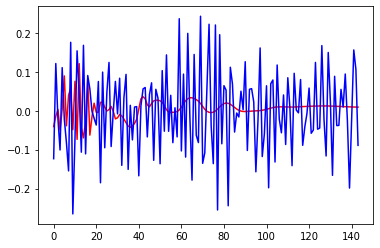

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


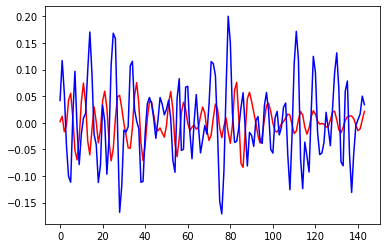

IMF:  2
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


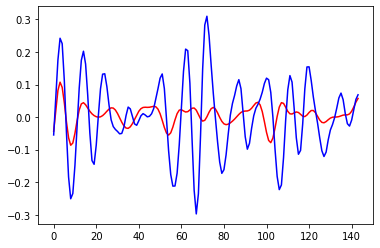

IMF:  3
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs


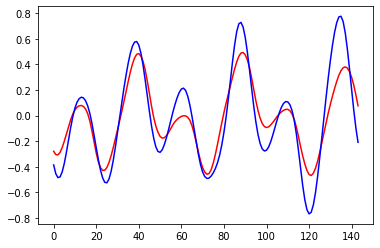

IMF:  4
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


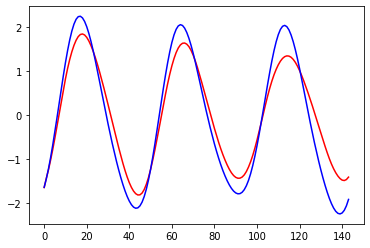

IMF:  5
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


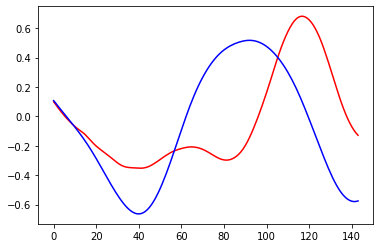

IMF:  6
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.48 µs


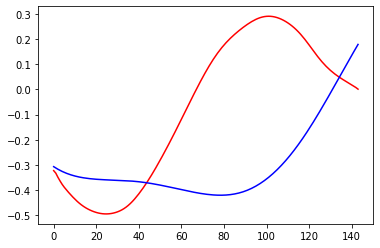

IMF:  7
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


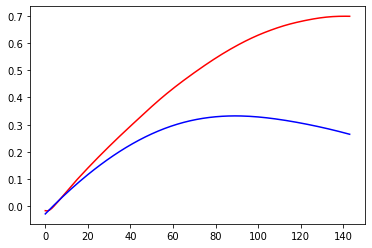

IMF:  8
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


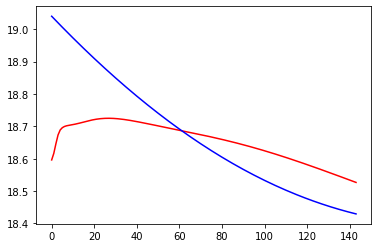

In [10]:


#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])


for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/'
  filename = f"{base_filename}{'S2_best_model_IMF'}_{m}.h5"
  loaded_model = load_model(filename)
  
  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S2_Top_Temp_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S2_Top_Temp_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S2_Top_VWC_Avg','Rain','S2_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df
  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)
  
  plt.plot(y_hat[0], color = 'red')
  plt.plot(test_y[0], color = 'blue')
  plt.show();

**S 7**

IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


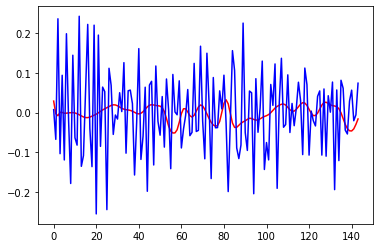

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


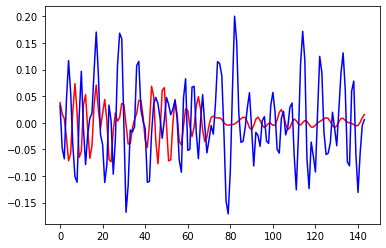

IMF:  2
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


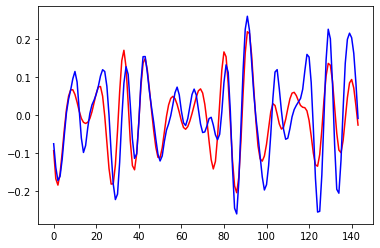

IMF:  3
CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 22.4 µs


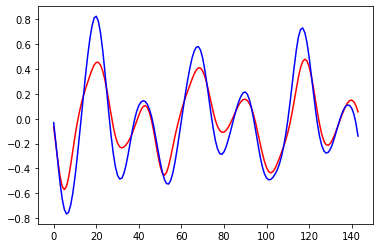

IMF:  4
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


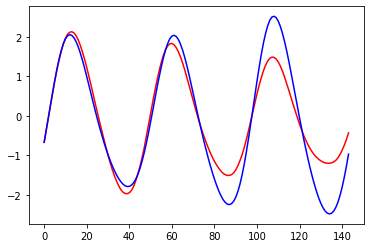

IMF:  5
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


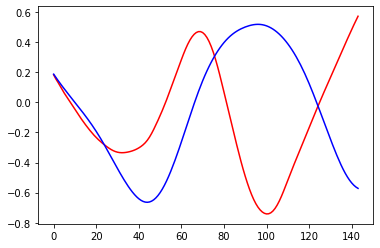

IMF:  6
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


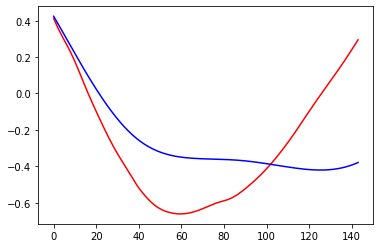

IMF:  7
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


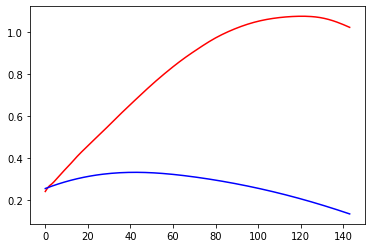

IMF:  8
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


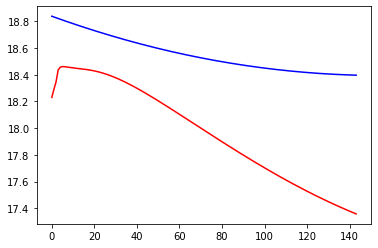

In [11]:


#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])


for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S7_best_model_IMF'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)
  
  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S7_Top_Temp_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S7_Top_Temp_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S7_Top_VWC_Avg','Rain','S7_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

 
  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  plt.plot(y_hat[0], color = 'red')
  plt.plot(test_y[0], color = 'blue')
  plt.show();

**S 11**

IMF:  0
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


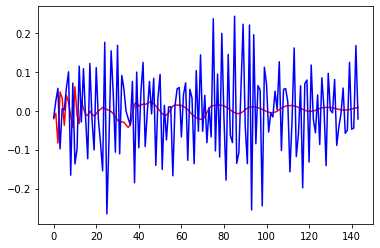

IMF:  1
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


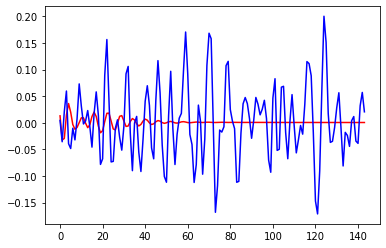

IMF:  2
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


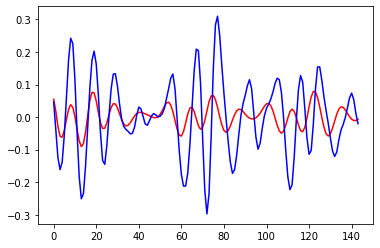

IMF:  3
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


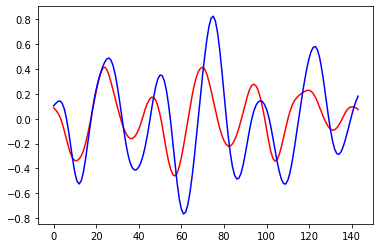

IMF:  4
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


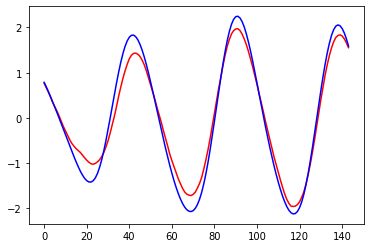

IMF:  5
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


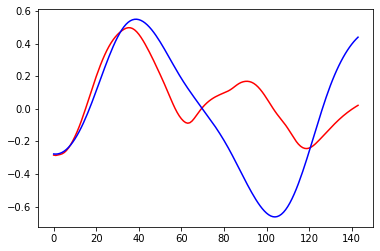

IMF:  6
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


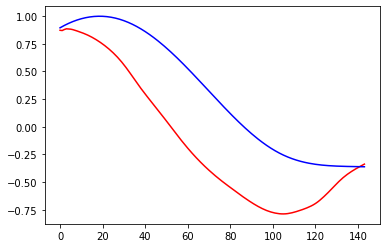

IMF:  7
CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.48 µs


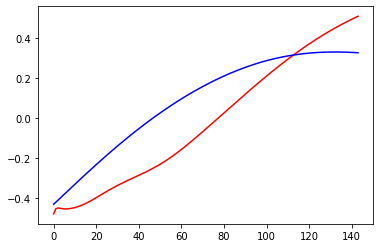

IMF:  8
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


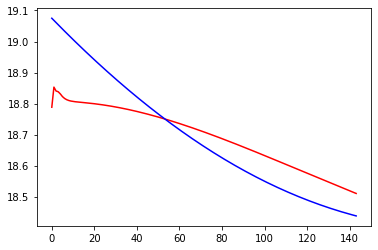

In [ ]:


#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])


for m in range(0, 9):

  base_filename = '/content/drive/Shareddrives/1st Paper/Performance/S11_best_model_IMF'
  filename = f"{base_filename}_{m}.h5"
  loaded_model = load_model(filename)
  
  print('IMF: ', m)
  data = pd.DataFrame(IMFs[m]).T
  data.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']

  data = data

  %time
  External = data[['Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                 'Wind Speed', 'Solar Radiation']]
  Predicted = data[['S11_Top_Temp_Avg']]
  index = pd.DataFrame(dataset.index)
  var = pd.DataFrame(StandardScaler().fit_transform(External))
  #var = data
  df = pd.concat([index, data['S11_Top_Temp_Avg'], var], axis = 1)
  df = df.set_index('Date Time')
  df.columns = ['S11_Top_VWC_Avg','Rain','S11_Top_Temp_Avg','Temp', 'Relative Humidity',
                  'Wind Speed', 'Solar Radiation']
  df_s = df

  train, test = split_dataset(df_s.values)

  # Preprocess the test set
  # Preprocess the test set

  n_input = loaded_model.get_config()['layers'][0]['config']['batch_input_shape'][1]

  test_X, test_y = to_supervised(test, n_input)

  y_h = loaded_model.evaluate(test_X[0].reshape(1,n_input,7), test_y[0].reshape(1,144), verbose=0)
  y_hat = loaded_model.predict(test_X, verbose = 0)

  plt.plot(y_hat[0], color = 'red')
  plt.plot(test_y[0], color = 'blue')
  plt.show();

In [ ]:
y_h

[0.08439621329307556,
 0.08439621329307556,
 0.010074465535581112,
 0.4500412940979004,
 0.7137812376022339]